In [ ]:

%load_ext autoreload
%autoreload 2



ModuleNotFoundError: No module named 'imp'

In [3]:
from pathlib import Path
import os
try :
    from google.colab import drive
    from pathlib import Path
    import os

    # Montar Drive
    drive.mount('/content/drive')

    # Rutas posibles
    paths = [
        "/content/drive/MyDrive/Proyecto_final",
        "/content/drive/MyDrive/Accesos directos/Proyecto_final",
        "/content/drive/MyDrive/Shortcuts/Proyecto_final",
        "/content/drive/MyDrive/Tp_final_vision"
    ]


    # Buscar cuál existe
    for p in paths:
        if Path(p).exists():
            BASE_DIR = Path(p)
            print(f"✅ Proyecto encontrado en: {BASE_DIR}")
            os.chdir(BASE_DIR)
            break
    else:
        raise FileNotFoundError("⚠️ No se encontró la carpeta TP_Colorizacion. Revisá el nombre del acceso directo.")

    # Confirmar contenido
    print("📁 Archivos encontrados:")
    for f in list(BASE_DIR.iterdir())[:10]:
        print("  ", f.name)
    DATA_DIR = Path("/content/imagewoof2-160")

except ImportError:
    DATA_DIR = Path("/imagewoof2-160")

    print("Entorno local detectado.")


Mounted at /content/drive
✅ Proyecto encontrado en: /content/drive/MyDrive/Tp_final_vision
📁 Archivos encontrados:
   __pycache__
   .DS_Store
   README.md
   imagewoof2-160
   models
   pesos_entrenados
   utils
   .git
   .gitignore
   final.ipynb


In [6]:
!rm -rf /content/imagewoof2-160  # limpia si existía
# !cp -r "/content/drive/MyDrive/Proyecto_final/imagewoof2-160" /content/
!cp -r "/content/drive/MyDrive/Tp_final_vision/imagewoof2-160" /content/


In [7]:
import torch
print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
!nvidia-smi


CUDA disponible: True
GPU: Tesla T4
Fri Nov 14 16:35:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             12W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------

In [8]:
# =============================================
# Preparación del dataset Imagewoof para colorización
# =============================================
import os
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.color import rgb2lab, lab2rgb
from PIL import Image
import matplotlib.pyplot as plt
from utils.utils import ImagewoofColorizationDataset




In [9]:
DATA_DIR = Path("imagewoof2-160")

# ---------------------------------------------
# Crear datasets
# ---------------------------------------------
train_dataset = ImagewoofColorizationDataset(DATA_DIR, split="train")
val_dataset   = ImagewoofColorizationDataset(DATA_DIR, split="val")

# ---------------------------------------------
# Crear DataLoaders (sin multiprocessing)
# ---------------------------------------------
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)


In [10]:


print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

# ---------------------------------------------
# Probar una muestra del DataLoader
# ---------------------------------------------
L_batch, ab_batch = next(iter(train_loader))
print("Shape canal L:", L_batch.shape)   # [batch, 1, H, W]
print("Shape canales ab:", ab_batch.shape)  # [batch, 2, H, W]


Train samples: 9025
Val samples: 3929
Shape canal L: torch.Size([16, 1, 224, 224])
Shape canales ab: torch.Size([16, 2, 224, 224])


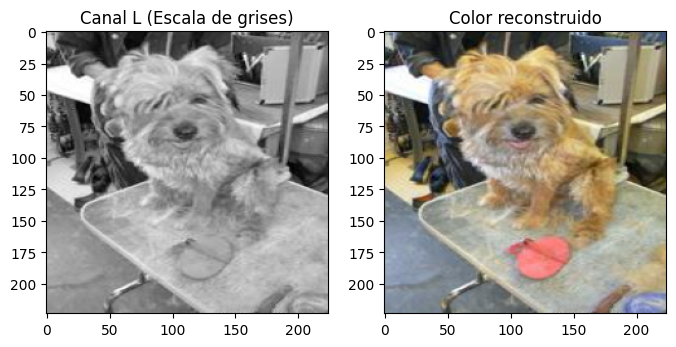

In [ ]:
# ---------------------------------------------
# Visualizar una muestra reconstruida (opcional)
# ---------------------------------------------
L_sample = L_batch[2]
ab_sample = ab_batch[2]

# Reconstruir imagen RGB aproximada
lab = torch.cat((L_sample, ab_sample), dim=0).permute(1, 2, 0).numpy()
rgb = lab2rgb(lab * [100, 128, 128])

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(L_sample.squeeze(), cmap='gray')
plt.title("Canal L (Escala de grises)")

plt.subplot(1,2,2)
plt.imshow(rgb)
plt.title("Color reconstruido")
plt.show()


ENCODER

In [11]:
import torch.optim as optim
from tqdm import tqdm
from models.encoder import FastColorNet
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", device)

# Redimensionar imágenes a 128×128 para acelerar
train_dataset = ImagewoofColorizationDataset(DATA_DIR, img_size=128, split="train")
val_dataset   = ImagewoofColorizationDataset(DATA_DIR, img_size=128, split="val")

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)


Usando: cuda


In [12]:
!pip install pytorch-msssim


In [20]:
from utils.trainer import trainer

def train_model(model, train_loader, val_loader, save_name, criterion ="l1"):
    save_path = "pesos_entrenados"
    model_path = Path(save_path) / save_name

    train= False  # Cambia a True para forzar el reentrenamiento

    # Verificar si ya existe un modelo entrenado
    if model_path.exists() and not train:
        print(f"✅ Modelo ya entrenado encontrado en '{model_path}'.")
        print("No se vuelve a entrenar para evitar sobreescritura.")
    else:
        print("🚀 No se encontró modelo entrenado, iniciando entrenamiento...")
        trainer(
            model,
            train_loader,
            val_loader,
            epochs=10,
            save_path=save_path,
            save_name=save_name,
            criterion=criterion
        )
        print(f"💾 Modelo guardado en: {model_path}")

FASTCOLORNET

In [ ]:
model = FastColorNet()
save_name = "fastColorNet.pt"
train_model(model, train_loader, val_loader, save_name)


✅ Modelo ya entrenado encontrado en 'pesos_entrenados/fastColorNet.pt'.
No se vuelve a entrenar para evitar sobreescritura.


In [ ]:
from utils.visualize import visualize_colorization, visualize_ranked_colorizations
# Cargar mejor modelo si hace falta
model = FastColorNet()
model.load_state_dict(torch.load("pesos_entrenados/fastColorNet.pt"))
# Visualizar resultados
visualize_colorization(model, val_loader, num_samples=5)
visualize_ranked_colorizations(model, val_loader, num_each=3, criterion=nn.L1Loss(reduction="none"))


UNET con metrica L1

In [ ]:
from models.unet import UNetColor

model = UNetColor()
save_name = "unetColor.pt"
train_model(model, train_loader, val_loader, save_name)


✅ Modelo ya entrenado encontrado en 'pesos_entrenados/unetColor.pt'.
No se vuelve a entrenar para evitar sobreescritura.


In [ ]:
model = UNetColor()
# Evita el error cuando el checkpoint fue guardado en GPU pero ahora estamos en CPU
state = torch.load("pesos_entrenados/unetColor.pt", map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()

visualize_colorization(model, val_loader, num_samples=5)

visualize_ranked_colorizations(model, val_loader, num_each=3, criterion=nn.L1Loss(reduction="none"))


UNET con metrica L1 + SSIM

In [ ]:

# Configuración del modelo y ruta
model = UNetColor()
save_name = "unetColorSSIM.pt"
train_model(model, train_loader, val_loader, save_name, criterion='combined')

✅ Modelo ya entrenado encontrado en 'pesos_entrenados/unetColorSSIM.pt'.
No se vuelve a entrenar para evitar sobreescritura.


In [ ]:
model = UNetColor()
state = torch.load("pesos_entrenados/unetColorSSIM.pt", map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()

visualize_colorization(model, val_loader, num_samples=5)

visualize_ranked_colorizations(model, val_loader, num_each=3, criterion=nn.L1Loss(reduction="none"))


In [ ]:
import os
import shutil
from pathlib import Path

# --- Configuración de carpetas ---
LOCAL_SAVE_DIR = Path("/content/pesos_entrenados")
RESULTS_DIR = Path("/content/resultados")

DRIVE_SAVE_DIR = Path("/content/drive/MyDrive/Proyecto_final/pesos_entrenados")
DRIVE_RESULTS_DIR = Path("/content/drive/MyDrive/Proyecto_final/resultados")

def backup_to_drive():
    """
    Copia los modelos y resultados desde el almacenamiento local (/content/)
    al Google Drive del proyecto.
    """
    # Crear carpetas destino si no existen
    DRIVE_SAVE_DIR.mkdir(parents=True, exist_ok=True)
    DRIVE_RESULTS_DIR.mkdir(parents=True, exist_ok=True)

    # Copiar modelos entrenados
    if LOCAL_SAVE_DIR.exists():
        print(f"📤 Copiando modelos desde {LOCAL_SAVE_DIR} → {DRIVE_SAVE_DIR}")
        for file in LOCAL_SAVE_DIR.glob("*.pt"):
            shutil.copy(file, DRIVE_SAVE_DIR)
            print(f"   ✅ {file.name} guardado en Drive")

    # Copiar resultados (gráficos, imágenes, etc.)
    if RESULTS_DIR.exists():
        print(f"📸 Copiando resultados desde {RESULTS_DIR} → {DRIVE_RESULTS_DIR}")
        for file in RESULTS_DIR.glob("*"):
            shutil.copy(file, DRIVE_RESULTS_DIR / file.name)
            print(f"   ✅ {file.name} guardado en Drive")

    print("✅ Backup completo en Google Drive.")

# --- Ejecutar al final del entrenamiento ---
backup_to_drive()


RED CON UN ENCODER PRE-ENTRENADO

Unet con un encoder resnet34 entrenado en ImageNet (metrica l1)

In [14]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.3 MB/s eta 0:00:00


In [12]:
from models.unet_resnet34 import get_model_unet_resnet34

# Variante 1: encoder preentrenado y entrenás todo
model = get_model_unet_resnet34(pre_entrenado=True, congelar_encoder=False)
save_name = "unet_resnet34_l1.pt"
train_model(model, train_loader, val_loader, save_name, criterion="l1")



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

🚀 No se encontró modelo entrenado, iniciando entrenamiento...
Entrenando en: cuda
Usando criterio: l1


/content/drive/Othercomputers/Mi PC/Tp_final_vision/utils/trainer.py:74: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
Época 1/10:   0%|          | 0/1129 [00:00<?, ?it/s]/content/drive/Othercomputers/Mi PC/Tp_final_vision/utils/trainer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
Época 1/10: 100%|██████████| 1129/1129 [01:55<00:00,  9.79it/s, loss=0.0543]


Época 01 | Train Loss: 0.0692 | Val Loss: 0.0778
✅ Nuevo mejor modelo guardado (Val Loss=0.0778)


Época 2/10: 100%|██████████| 1129/1129 [01:48<00:00, 10.38it/s, loss=0.0499]


Época 02 | Train Loss: 0.0665 | Val Loss: 0.0714
✅ Nuevo mejor modelo guardado (Val Loss=0.0714)


Época 3/10: 100%|██████████| 1129/1129 [01:50<00:00, 10.18it/s, loss=0.1112]


Época 03 | Train Loss: 0.0658 | Val Loss: 0.0747


Época 4/10: 100%|██████████| 1129/1129 [01:46<00:00, 10.56it/s, loss=0.0524]


Época 04 | Train Loss: 0.0652 | Val Loss: 0.0645
✅ Nuevo mejor modelo guardado (Val Loss=0.0645)


Época 5/10: 100%|██████████| 1129/1129 [01:49<00:00, 10.29it/s, loss=0.0836]


Época 05 | Train Loss: 0.0648 | Val Loss: 0.0716


Época 6/10: 100%|██████████| 1129/1129 [01:46<00:00, 10.63it/s, loss=0.0674]


Época 06 | Train Loss: 0.0644 | Val Loss: 0.0648


Época 7/10: 100%|██████████| 1129/1129 [01:46<00:00, 10.60it/s, loss=0.0756]


Época 07 | Train Loss: 0.0642 | Val Loss: 0.0657


Época 8/10: 100%|██████████| 1129/1129 [01:47<00:00, 10.46it/s, loss=0.0337]


Época 08 | Train Loss: 0.0639 | Val Loss: 0.0650


Época 9/10: 100%|██████████| 1129/1129 [01:47<00:00, 10.46it/s, loss=0.1396]


Época 09 | Train Loss: 0.0637 | Val Loss: 0.0619
✅ Nuevo mejor modelo guardado (Val Loss=0.0619)


Época 10/10: 100%|██████████| 1129/1129 [01:53<00:00,  9.97it/s, loss=0.0677]


Época 10 | Train Loss: 0.0634 | Val Loss: 0.0630
Entrenamiento finalizado.
Mejor Val Loss: 0.0619
💾 Modelo guardado en: pesos_entrenados/unet_resnet34_l1.pt


RED CON UN ENCODER PRE-ENTRENADO

Unet con un encoder resnet34 entrenado en ImageNet (metrica l1 + SSIM)


In [ ]:
model = get_model_unet_resnet34(pre_entrenado=True, congelar_encoder=False)
save_name = "unet_resnet34_combined.pt"
train_model(model, train_loader, val_loader, save_name, criterion="combined")


🚀 No se encontró modelo entrenado, iniciando entrenamiento...
Entrenando en: cuda
Usando criterio: combined


Época 1/10: 100%|██████████| 1129/1129 [01:55<00:00,  9.80it/s, loss=0.1596]


Época 01 | Train Loss: 0.1664 | Val Loss: 0.1538
✅ Nuevo mejor modelo guardado (Val Loss=0.1538)


Época 2/10: 100%|██████████| 1129/1129 [01:50<00:00, 10.21it/s, loss=0.1522]


Época 02 | Train Loss: 0.1552 | Val Loss: 0.1546


Época 3/10: 100%|██████████| 1129/1129 [01:49<00:00, 10.32it/s, loss=0.1156]


Época 03 | Train Loss: 0.1548 | Val Loss: 0.1527
✅ Nuevo mejor modelo guardado (Val Loss=0.1527)


Época 4/10: 100%|██████████| 1129/1129 [01:57<00:00,  9.59it/s, loss=0.2840]


Época 04 | Train Loss: 0.1544 | Val Loss: 0.1525
✅ Nuevo mejor modelo guardado (Val Loss=0.1525)


Época 5/10: 100%|██████████| 1129/1129 [01:51<00:00, 10.08it/s, loss=0.1666]


Época 05 | Train Loss: 0.1535 | Val Loss: 0.1515
✅ Nuevo mejor modelo guardado (Val Loss=0.1515)


Época 6/10: 100%|██████████| 1129/1129 [01:58<00:00,  9.53it/s, loss=0.1506]


Época 06 | Train Loss: 0.1529 | Val Loss: 0.1872


Época 7/10: 100%|██████████| 1129/1129 [01:50<00:00, 10.20it/s, loss=0.1380]


Época 07 | Train Loss: 0.1522 | Val Loss: 0.1487
✅ Nuevo mejor modelo guardado (Val Loss=0.1487)


Época 8/10: 100%|██████████| 1129/1129 [01:52<00:00, 10.05it/s, loss=0.1990]


Época 08 | Train Loss: 0.1510 | Val Loss: 0.1509


Época 9/10: 100%|██████████| 1129/1129 [01:51<00:00, 10.11it/s, loss=0.1681]


Época 09 | Train Loss: 0.1506 | Val Loss: 0.1493


Época 10/10: 100%|██████████| 1129/1129 [01:53<00:00,  9.91it/s, loss=0.2232]


In [21]:
model = get_model_unet_resnet34(pre_entrenado=True, congelar_encoder=True)
save_name = "unet_resnet34_frozen_l1.pt"
train_model(model, train_loader, val_loader, save_name, criterion="l1")


🚀 No se encontró modelo entrenado, iniciando entrenamiento...
Entrenando en: cuda
Usando criterio: l1


/content/drive/Othercomputers/Mi PC/Tp_final_vision/utils/trainer.py:74: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
Época 1/10:   0%|          | 0/1129 [00:00<?, ?it/s]/content/drive/Othercomputers/Mi PC/Tp_final_vision/utils/trainer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
Época 1/10: 100%|██████████| 1129/1129 [01:20<00:00, 14.09it/s, loss=0.1143]


Época 01 | Train Loss: 0.0688 | Val Loss: 0.0631
✅ Nuevo mejor modelo guardado (Val Loss=0.0631)


Época 2/10: 100%|██████████| 1129/1129 [01:19<00:00, 14.22it/s, loss=0.1041]


Época 02 | Train Loss: 0.0637 | Val Loss: 0.0623
✅ Nuevo mejor modelo guardado (Val Loss=0.0623)


Época 3/10: 100%|██████████| 1129/1129 [01:20<00:00, 13.98it/s, loss=0.0934]


Época 03 | Train Loss: 0.0627 | Val Loss: 0.0608
✅ Nuevo mejor modelo guardado (Val Loss=0.0608)


Época 4/10: 100%|██████████| 1129/1129 [01:24<00:00, 13.42it/s, loss=0.0645]


Época 04 | Train Loss: 0.0618 | Val Loss: 0.0594
✅ Nuevo mejor modelo guardado (Val Loss=0.0594)


Época 5/10: 100%|██████████| 1129/1129 [01:19<00:00, 14.20it/s, loss=0.0449]


Época 05 | Train Loss: 0.0613 | Val Loss: 0.0600


Época 6/10: 100%|██████████| 1129/1129 [01:18<00:00, 14.43it/s, loss=0.0720]


Época 06 | Train Loss: 0.0607 | Val Loss: 0.0591
✅ Nuevo mejor modelo guardado (Val Loss=0.0591)


Época 7/10: 100%|██████████| 1129/1129 [01:19<00:00, 14.23it/s, loss=0.0615]


Época 07 | Train Loss: 0.0601 | Val Loss: 0.0587
✅ Nuevo mejor modelo guardado (Val Loss=0.0587)


Época 8/10: 100%|██████████| 1129/1129 [01:19<00:00, 14.14it/s, loss=0.1065]


Época 08 | Train Loss: 0.0598 | Val Loss: 0.0583
✅ Nuevo mejor modelo guardado (Val Loss=0.0583)


Época 9/10: 100%|██████████| 1129/1129 [01:19<00:00, 14.17it/s, loss=0.0814]


Época 09 | Train Loss: 0.0592 | Val Loss: 0.0589


Época 10/10: 100%|██████████| 1129/1129 [01:20<00:00, 14.08it/s, loss=0.0344]


Época 10 | Train Loss: 0.0588 | Val Loss: 0.0583
✅ Nuevo mejor modelo guardado (Val Loss=0.0583)
Entrenamiento finalizado.
Mejor Val Loss: 0.0583
💾 Modelo guardado en: pesos_entrenados/unet_resnet34_frozen_l1.pt


In [17]:
# ============================
# Visualizar U-Net ResNet34
# ============================
import torch
import torch.nn as nn
from models.unet_resnet34 import get_model_unet_resnet34
from utils.visualize import visualize_colorization, visualize_ranked_colorizations

# Asegurate de tener definido 'device' como antes
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Crear el modelo con la misma config que usaste al entrenar
model = get_model_unet_resnet34(pre_entrenado=True)

# 2) Cargar los pesos ya guardados
state = torch.load("pesos_entrenados/unet_resnet34_l1.pt", map_location=device)
model.load_state_dict(state)

# 3) Mandarlo a GPU/CPU y ponerlo en eval
model.to(device)
model.eval()

# 4) Visualizar algunas colorizaciones
visualize_colorization(model, val_loader, num_samples=5)

# 5) Visualizar ejemplos “buenos y malos” según L1
visualize_ranked_colorizations(
    model,
    val_loader,
    num_each=3,
    criterion=nn.L1Loss(reduction="none")
)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# ============================
# Visualizar U-Net ResNet34
# ============================
import torch
import torch.nn as nn
from models.unet_resnet34 import get_model_unet_resnet34
from utils.visualize import visualize_colorization, visualize_ranked_colorizations

# Asegurate de tener definido 'device' como antes
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Crear el modelo con la misma config que usaste al entrenar
model = get_model_unet_resnet34(pre_entrenado=True)

# 2) Cargar los pesos ya guardados
state = torch.load("pesos_entrenados/unet_resnet34_combined.pt", map_location=device)
model.load_state_dict(state)

# 3) Mandarlo a GPU/CPU y ponerlo en eval
model.to(device)
model.eval()

# 4) Visualizar algunas colorizaciones
visualize_colorization(model, val_loader, num_samples=5)

# 5) Visualizar ejemplos “buenos y malos” según L1
visualize_ranked_colorizations(
    model,
    val_loader,
    num_each=3,
    criterion=nn.L1Loss(reduction="none")
)

In [22]:
# ============================
# Visualizar U-Net ResNet34
# ============================
import torch
import torch.nn as nn
from models.unet_resnet34 import get_model_unet_resnet34
from utils.visualize import visualize_colorization, visualize_ranked_colorizations

# Asegurate de tener definido 'device' como antes
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Crear el modelo con la misma config que usaste al entrenar
model = get_model_unet_resnet34(pre_entrenado=True)

# 2) Cargar los pesos ya guardados
state = torch.load("pesos_entrenados/unet_resnet34_frozen_l1.pt", map_location=device)
model.load_state_dict(state)

# 3) Mandarlo a GPU/CPU y ponerlo en eval
model.to(device)
model.eval()

# 4) Visualizar algunas colorizaciones
visualize_colorization(model, val_loader, num_samples=5)

# 5) Visualizar ejemplos “buenos y malos” según L1
visualize_ranked_colorizations(
    model,
    val_loader,
    num_each=3,
    criterion=nn.L1Loss(reduction="none")
)

Output hidden; open in https://colab.research.google.com to view.